# Data Stuff

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2025-06-12 01:01:06.464021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749690066.895673      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749690067.009353      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
DATA_DIR = "/kaggle/input/food11-image-dataset"

In [3]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'training'),
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    seed=42
)

Found 9866 files belonging to 11 classes.


I0000 00:00:1749690103.628229      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749690103.628998      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## Class Samples by Dataset

In [4]:
train_data.class_names

['Bread',
 'Dairy product',
 'Dessert',
 'Egg',
 'Fried food',
 'Meat',
 'Noodles-Pasta',
 'Rice',
 'Seafood',
 'Soup',
 'Vegetable-Fruit']

In [5]:
# os.listdir(data_dir) # not the order i like
datasets = ['training', 'validation','evaluation']

In [6]:
records = []
for fldr in datasets:
    dataset_image_count = {}
    for sub_fldr in train_data.class_names:
        dataset_image_count[sub_fldr] = len(os.listdir(os.path.join(DATA_DIR, fldr, sub_fldr)))
    records.append(dataset_image_count)
df = pd.DataFrame(records, index=datasets)

class imbalance will probably cause issues, but not going to address them for this analysis

In [7]:
df

,Bread,Dairy product,Dessert,Egg,Fried food,Meat,Noodles-Pasta,Rice,Seafood,Soup,Vegetable-Fruit
training,994,429,1500,986,848,1325,440,280,855,1500,709
validation,362,144,500,327,326,449,147,96,347,500,232
evaluation,368,148,500,335,287,432,147,96,303,500,231


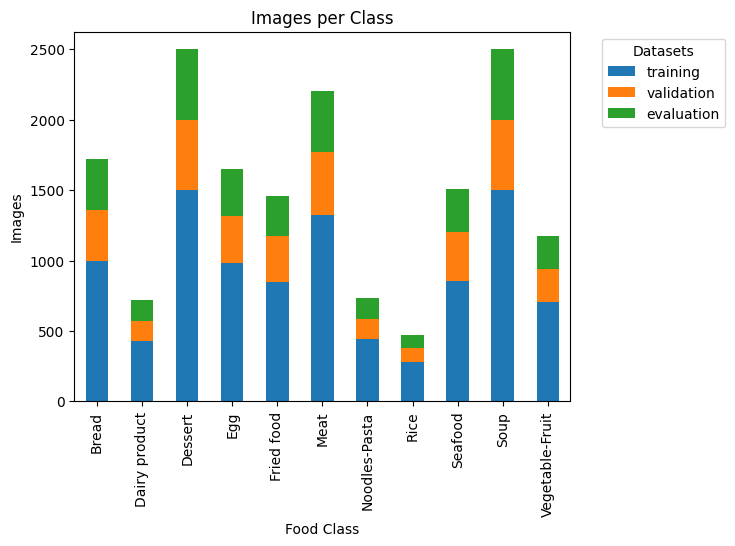

In [8]:
ax = df.T.plot(kind="bar", stacked=True)

# Add labels and title
ax.set_xlabel("Food Class")
ax.set_ylabel("Images")
ax.set_title("Images per Class")

ax.legend(title="Datasets", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

## Visualize Images

In [9]:
def show_random_images(
    classes,
    dataset='training',
    seed = None,
    n_images=1
):
    random.seed(seed)

    if isinstance(classes,str): # if you wanted to look at one class you can add arg as string instead of list
        classes = [classes]

    image_label_tuples = []
    for class_ in classes:
        images = os.listdir(os.path.join(DATA_DIR, dataset, class_))
        for _ in range(n_images):
            image = random.choice(images)
            image_label_tuples.append((
                os.path.join(DATA_DIR, dataset, class_, image),
                class_
            ))
            
    rows = 1 if len(image_label_tuples) <=4 else (len(image_label_tuples) + 3) // 4
    fig, ax = plt.subplots(
        rows, 
        4, 
        figsize = (8, 5)
    )

    if rows == 1:
        ax = np.array([ax])

    for i, tup in enumerate(image_label_tuples):
        ax[i // 4, i % 4].imshow(plt.imread(tup[0]))
        ax[i // 4, i % 4].set(title = tup[1])
        ax[i//4, i%4].axis('off')

    fig.show()

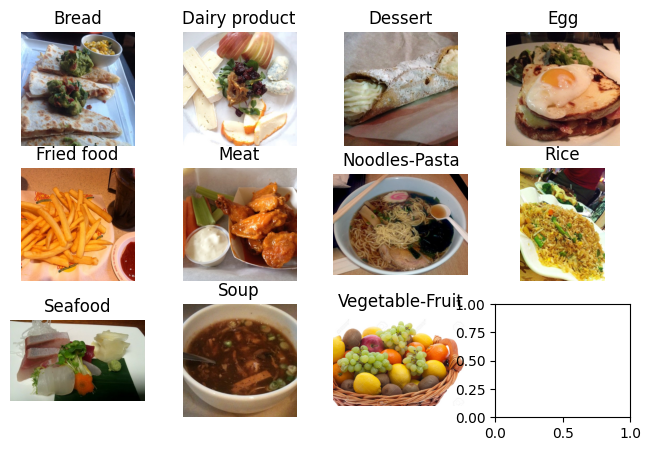

In [10]:
show_random_images(train_data.class_names)

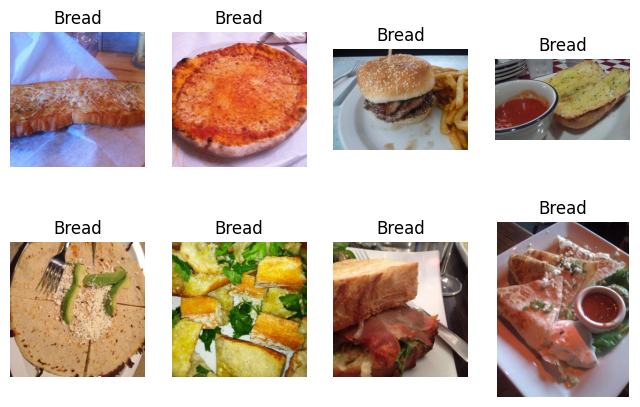

In [11]:
show_random_images('Bread', n_images=8, seed=42)

## Load Test/Valid Data

In [12]:
valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'validation'),
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    seed=42
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'evaluation'),
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    seed=42,
    shuffle=False
)

Found 3430 files belonging to 11 classes.
Found 3347 files belonging to 11 classes.


In [13]:
sample_batch = next(iter(train_data))
sample_batch[0][0][:2, :2, :]

<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
array([[[0.       , 3.127551 , 4.127551 ],
        [0.       , 2.0459182, 3.0459182]],

       [[0.       , 2.0459182, 3.0459182],
        [0.       , 3.8622453, 4.8622456]]], dtype=float32)>

In [14]:
sample_batch = next(iter(valid_data))
sample_batch[0][0][:2, :2, :]

<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
array([[[87.22959  ,  2.2295918,  9.229591 ],
        [87.64286  ,  0.6428572,  8.642858 ]],

       [[87.07143  ,  2.0714283,  9.071428 ],
        [88.       ,  1.       ,  9.       ]]], dtype=float32)>

## Data Augmentation Setup

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_data_generator = augmented = ImageDataGenerator(
    # rescale = 1/255, # can also rescale here
    rotation_range=.2, # 0 - 180 degress
    shear_range=.2, # shear anlge in degrees (distort image along axis to emulate image seen from different angles)
    zoom_range=.2, # amount of zoom (randomly picked within range)
    width_shift_range=.2, # shift by fraction (if <1, otherwise do number of pixels. will clip some of the image, and fill from where shifted.)
    height_shift_range=.2,# ^
    horizontal_flip=True # randomly flip images horizontally
)

# overwrite the train data from above
train_data = image_data_generator.flow_from_directory(
    os.path.join(DATA_DIR, 'validation'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

Found 3430 images belonging to 11 classes.


# Modeling

## Baseline Model

In [16]:
from tensorflow.keras.layers import Input, Rescaling, Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

In [17]:
baseline_model = Sequential([
    Input(shape=(224,224,3)),
    Rescaling(1./255),
    Conv2D(128,3, activation='relu'), # prob too much but we'll see I guess
    MaxPool2D(),
    Conv2D(64,3, activation='relu'),
    MaxPool2D(),
    Conv2D(32,3, activation='relu'),
    MaxPool2D(),
    Conv2D(16,3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(11, activation='softmax')
])

baseline_model.compile(
    # loss = 'sparse_categorical_crossentropy',
    loss = 'categorical_crossentropy',
    optimizer = Adam(),
    metrics=['accuracy']
)

In [18]:
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │          25,355 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,819 (491.48 KB)

 Trainable params: 125,819 (491.48 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'baseline_checkpoints.weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,  # cuts learning rate by half
    patience=3,  # 3 epochs before cutting
    min_lr=1e-5 
)

In [20]:
baseline_history = baseline_model.fit(
    train_data,
    epochs=5, # should train for longer but ok for this
    steps_per_epoch=len(train_data),
    validation_data = valid_data,
    validation_steps = len(valid_data),
    callbacks = [checkpoint_callback, reduce_lr_callback]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1749690206.943878     104 service.cc:148] XLA service 0x7ad4f802f480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749690206.945696     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749690206.945736     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749690207.357503     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/108 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.0859 - loss: 2.3970 

I0000 00:00:1749690216.292153     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


108/108 ━━━━━━━━━━━━━━━━━━━━ 100s 821ms/step - accuracy: 0.1582 - loss: 2.3234 - val_accuracy: 0.2006 - val_loss: 2.1905 - learning_rate: 0.0010
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 58s 541ms/step - accuracy: 0.1988 - loss: 2.1879 - val_accuracy: 0.2464 - val_loss: 2.0862 - learning_rate: 0.0010
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 57s 530ms/step - accuracy: 0.2236 - loss: 2.1224 - val_accuracy: 0.2350 - val_loss: 2.0960 - learning_rate: 0.0010
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 58s 536ms/step - accuracy: 0.2237 - loss: 2.1310 - val_accuracy: 0.2904 - val_loss: 2.0319 - learning_rate: 0.0010
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 58s 536ms/step - accuracy: 0.2668 - loss: 2.0909 - val_accuracy: 0.3085 - val_loss: 1.9694 - learning_rate: 0.0010


## Evaluate Training & Predictions

To keep notebook length in check. will only do this for the baseline model, not the better models. Would ideally do this kind of thing for each model created though.

In [43]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

def plot_history(history, metric:str|None=None):
    df = pd.DataFrame(history.history)
    if isinstance(metric, str):
        df = df[[c for c in df if metric in c]]
    df.plot()

def show_random_prediction(
    images, y_true, y_pred, pred_conf, label_map, n_images=8, seed = None
):

    random.seed(seed)
    
    rand_ints = random.sample(range(0, len(images)), n_images)

    samples = [] # (image, label, pred, conf)
    for i in rand_ints:
        samples.append((
            images[i],
            label_map[y_true[i]],
            label_map[y_pred[i]],
            pred_conf[i]
        ))

    n_cols = 2
    rows = 1 if len(samples) <=n_cols else (len(samples) + (n_cols-1)) // n_cols
    fig, ax = plt.subplots(
        rows, 
        n_cols, 
        figsize = (10, 7)
    )

    if rows == 1:
        ax = np.array([ax])

    for i, tup in enumerate(samples):
        if tup[1] == tup[2]:
            color = 'green'
        else:
            color = 'red'
            
        ax[i // n_cols, i % n_cols].imshow(tup[0])
        ax[i // n_cols, i % n_cols].set_title(f'Label: {tup[1]} Pred: {tup[2]}, Conf: {tup[3]}', color=color)
        ax[i//n_cols, i%n_cols].axis('off')

def get_confusion_matrix(y_true, y_pred, class_names):
    matrix = confusion_matrix(y_true, y_pred, normalize='true')
    matrix = np.round(matrix * 100, 1)
    fig = px.imshow(
        matrix,
        x = class_names,
        y = class_names,
    )
    
    fig.update_traces(text=matrix, texttemplate="%{text}", textfont=dict(color="white"))

    fig.update_layout(
        xaxis_title="Preds", # probably.. irl check this,
        yaxis_title="Labels"
    )
    
    fig.show()

def stacked_bar_by_decile(input_df, column, group_col, title='Stacked Bar Chart by Decile'):
    df = input_df.copy()
    df['Decile'] = pd.qcut(df[group_col], q=10, labels=False)
    ct = pd.crosstab(df['Decile'], df[column])
    
    plt.figure(figsize=(10, 7))
    ct.plot.bar(stacked=True)
    plt.title(title)
    plt.xlabel('Decile (Most -> Least Confident)')
    plt.ylabel(f'{column}_Count')
    plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [22]:
baseline_model.evaluate(test_data)

105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.2337 - loss: 2.0492


[2.0133259296417236, 0.3041529655456543]

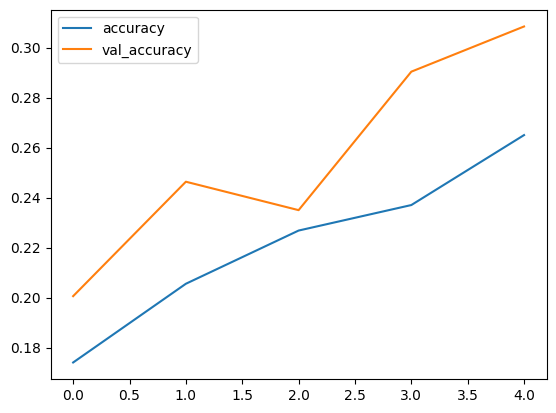

In [23]:
plot_history(baseline_history, 'accuracy')

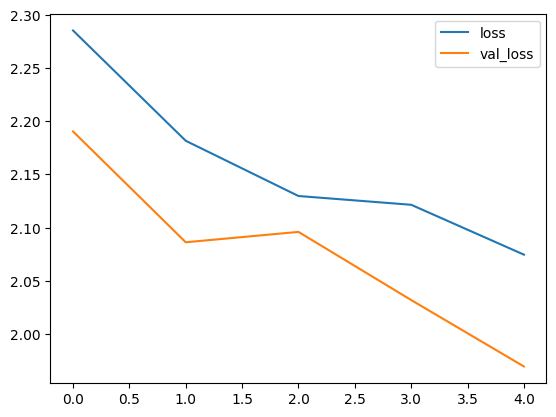

In [24]:
plot_history(baseline_history, 'loss')

In [25]:
baseline_pred_prob = baseline_model.predict(test_data)

105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step


In [27]:
baseline_pred = [arr.argmax() for arr in baseline_pred_prob]
baseline_conf = [round(arr.max()*100,1) for arr in baseline_pred_prob]

In [28]:
baseline_pred[:3], baseline_conf[:3]

([0, 2, 3], [23.2, 17.3, 27.9])

In [29]:
images = []
y_labels = []
for img, label in test_data.unbatch():
    images.append(img/255)
    y_labels.append(label.numpy().argmax())
y_labels[:3]

[0, 0, 0]

In [30]:
# just to make sure i didnt mess anything up :)
len(y_labels), len(baseline_pred)

(3347, 3347)

In [31]:
label_map = {i:class_ for i,class_ in enumerate(valid_data.class_names)}
label_map

{0: 'Bread',
 1: 'Dairy product',
 2: 'Dessert',
 3: 'Egg',
 4: 'Fried food',
 5: 'Meat',
 6: 'Noodles-Pasta',
 7: 'Rice',
 8: 'Seafood',
 9: 'Soup',
 10: 'Vegetable-Fruit'}

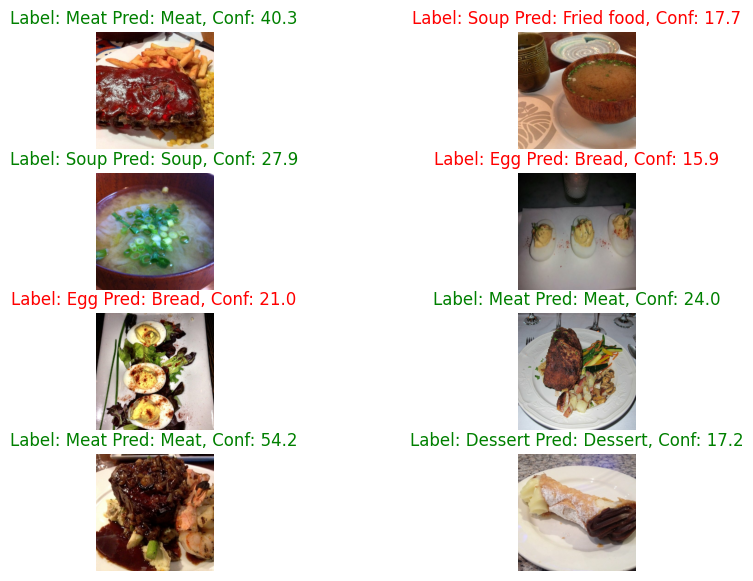

In [33]:
show_random_prediction(
    images, 
    y_labels, 
    baseline_pred, 
    baseline_conf, 
    label_map,
    n_images=8
)

In [34]:
# no shock but is stuggling with classes with fewer images (dairy, noodles-pasta, rice)
    # most likely due to class imbalance
print(
    classification_report(
        [label_map[l] for l in y_labels],
        [label_map[p] for p in baseline_pred], 
        zero_division=1
    )
)

                 precision    recall  f1-score   support

          Bread       0.14      0.15      0.14       368
  Dairy product       0.42      0.07      0.12       148
        Dessert       0.42      0.23      0.29       500
            Egg       0.28      0.16      0.20       335
     Fried food       0.19      0.60      0.29       287
           Meat       0.39      0.67      0.49       432
  Noodles-Pasta       1.00      0.00      0.00       147
           Rice       1.00      0.00      0.00        96
        Seafood       0.31      0.15      0.20       303
           Soup       0.38      0.32      0.35       500
Vegetable-Fruit       0.44      0.53      0.48       231

       accuracy                           0.30      3347
      macro avg       0.45      0.26      0.23      3347
   weighted avg       0.38      0.30      0.28      3347



In [44]:
# normalized (rows will equal 1.0)
get_confusion_matrix(y_labels, baseline_pred, valid_data.class_names)

In [45]:
model_preds_df = pd.DataFrame({
    'label':y_labels,
    'pred':baseline_pred,
    'conf':baseline_conf,
})
model_preds_df.head()

,label,pred,conf
0,0,0,23.2
1,0,2,17.3
2,0,3,27.9
3,0,0,21.9
4,0,10,34.0


In [46]:
wrong_preds = model_preds_df[model_preds_df.label != model_preds_df.pred].sort_values(by='conf', ascending=False)
wrong_preds.head()

,label,pred,conf
2246,7,10,78.4
2751,9,10,70.7
210,0,10,66.8
1007,2,5,64.9
395,1,10,62.8


In [47]:
label= 10
print(f'Worst predictions for {label_map[label]}')
wrong_preds[wrong_preds.label==label].head(10)

Worst predictions for Vegetable-Fruit


,label,pred,conf
3171,10,5,53.2
3225,10,2,50.0
3254,10,5,45.3
3232,10,2,44.2
3279,10,2,41.6
3330,10,5,41.4
3231,10,3,35.7
3253,10,5,35.6
3263,10,0,35.4
3212,10,5,35.3


In [48]:
correct_preds = model_preds_df[model_preds_df.label == model_preds_df.pred].sort_values(by='conf', ascending=False)

<Figure size 1000x700 with 0 Axes>

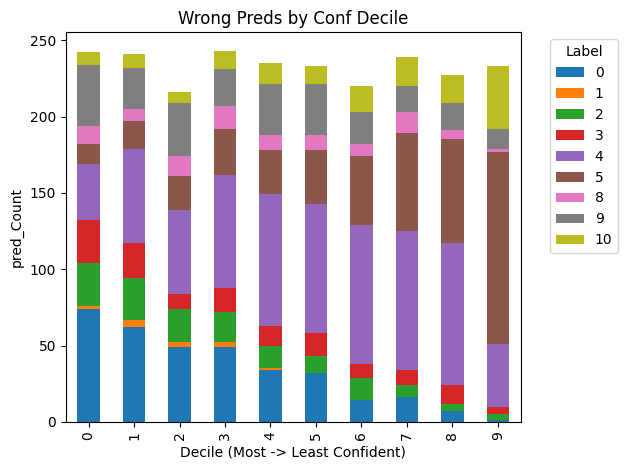

<Figure size 1000x700 with 0 Axes>

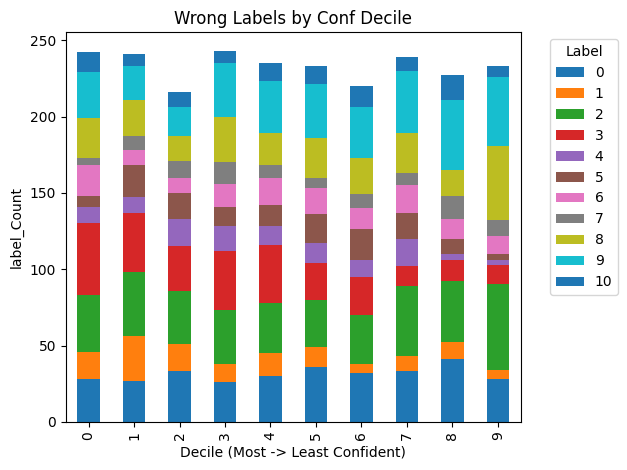

<Figure size 1000x700 with 0 Axes>

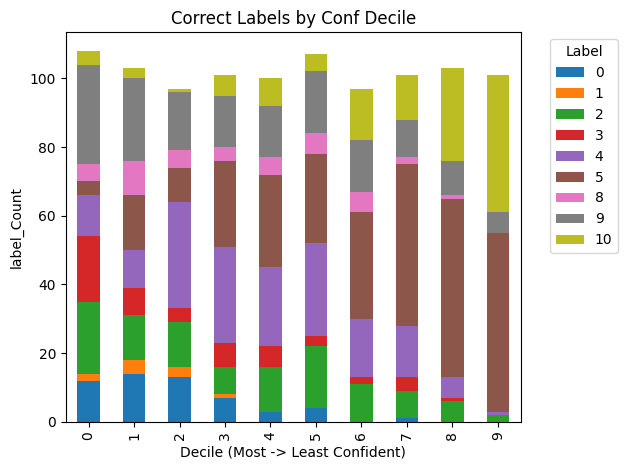

In [49]:
stacked_bar_by_decile(wrong_preds, 'pred', 'conf', 'Wrong Preds by Conf Decile')
stacked_bar_by_decile(wrong_preds, 'label', 'conf', 'Wrong Labels by Conf Decile')
stacked_bar_by_decile(correct_preds, 'label', 'conf', 'Correct Labels by Conf Decile')

## Better Model -- Feature Extraction

In [50]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [51]:
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout

In [52]:
# efficientnet needs non rescaled values:

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'training'),
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    seed=42
)

Found 9866 files belonging to 11 classes.


In [53]:
inputs = Input(shape=(224,224, 3), name='input_layer')

x = base_model(inputs, training=False)

x = Dropout(.2)(x) # can put here or after pooling.. both may be overkill

# classes are very different and theres only 11, whereas model trained on 101 i think 
    # so max pool may work better?
x = GlobalMaxPooling2D(name='global_max_pooling_layer')(x)
# x = GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)

# x = Dropout(.2)(x)

outputs = Dense(
    11,
    activation='softmax',
    name='output_layer'
)(x)

better_model = tf.keras.Model(inputs, outputs)

In [54]:
better_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling_layer             │ (None, 1280)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 11)                  │          14,091 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,063,662 (15.50 MB)

 Trainable params: 14,091 (55.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [55]:
better_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [56]:
feat_extract_history = better_model.fit(
    train_data,
    epochs=5,# will just do 5/5 for feat_extract/fine_tune
    steps_per_epoch=len(train_data),
    validation_data = valid_data,
    validation_steps = len(valid_data),
    callbacks = [checkpoint_callback, reduce_lr_callback]
)

Epoch 1/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 82s 178ms/step - accuracy: 0.5249 - loss: 2.3251 - val_accuracy: 0.7752 - val_loss: 0.8308 - learning_rate: 0.0010
Epoch 2/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.7899 - loss: 0.8505 - val_accuracy: 0.8009 - val_loss: 0.7106 - learning_rate: 0.0010
Epoch 3/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.8349 - loss: 0.6057 - val_accuracy: 0.8055 - val_loss: 0.7215 - learning_rate: 0.0010
Epoch 4/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.8578 - loss: 0.5331 - val_accuracy: 0.8262 - val_loss: 0.6038 - learning_rate: 0.0010
Epoch 5/5
309/309 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.8703 - loss: 0.4675 - val_accuracy: 0.8149 - val_loss: 0.6757 - learning_rate: 0.0010


In [57]:
better_model.evaluate(test_data)

105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.7764 - loss: 0.8269


[0.63118976354599, 0.8344786167144775]

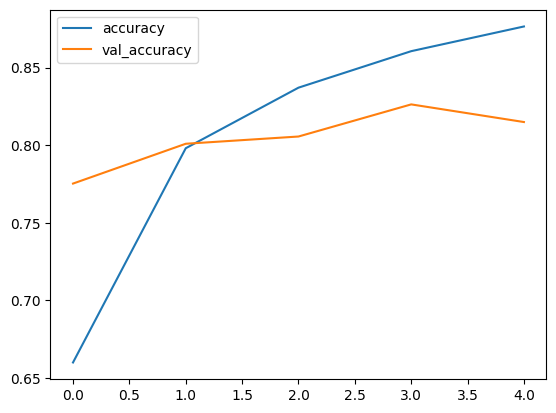

In [58]:
plot_history(feat_extract_history, 'accuracy')

## Better Model -- Fine Tune

In [59]:
base_model.trainable = True

# refreeze each layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [61]:
better_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), # lowered by 10x
    metrics=['accuracy']
)

In [62]:
feat_extract_history.epoch[-1]

4

In [64]:
 fine_tune_history = better_model.fit(
    train_data,
    epochs=10, # NOTE. adding to epochs completed already
    initial_epoch=feat_extract_history.epoch[-1],
    validation_data=valid_data,
    validation_steps=len(valid_data),
    callbacks = [checkpoint_callback]
)

Epoch 5/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.9729 - loss: 0.0845 - val_accuracy: 0.8752 - val_loss: 0.4483
Epoch 6/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9822 - loss: 0.0622 - val_accuracy: 0.8755 - val_loss: 0.4396
Epoch 7/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.9796 - loss: 0.0621 - val_accuracy: 0.8799 - val_loss: 0.4469
Epoch 8/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.9834 - loss: 0.0525 - val_accuracy: 0.8822 - val_loss: 0.4293
Epoch 9/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.9857 - loss: 0.0468 - val_accuracy: 0.8764 - val_loss: 0.4382
Epoch 10/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.9872 - loss: 0.0415 - val_accuracy: 0.8840 - val_loss: 0.4173


## Better Model Eval (short version)

Won't do the entire eval I did for the baseline model because I'm not going to build any additional models. If I were to continue analysis / try to build a better model options would be:

- Train for longer (more epochs)
- Try different layers for Feature Extract model (AvgPool, another dropout, more dropping etc.)
- Try unfreezing more/less layers in tuned model
- Try different base model
- Can try different augmentations
- Find where model is predicting worse and see if those images should be removed

In [65]:
better_pred_prob = better_model.predict(test_data)

105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step


In [66]:
better_pred = [arr.argmax() for arr in better_pred_prob]

In [67]:
print(
    classification_report(
        [label_map[l] for l in y_labels],
        [label_map[p] for p in better_pred], 
        zero_division=1
    )
)

                 precision    recall  f1-score   support

          Bread       0.88      0.85      0.87       368
  Dairy product       0.85      0.79      0.82       148
        Dessert       0.86      0.87      0.87       500
            Egg       0.91      0.87      0.89       335
     Fried food       0.84      0.89      0.86       287
           Meat       0.90      0.92      0.91       432
  Noodles-Pasta       0.97      0.99      0.98       147
           Rice       0.93      0.89      0.91        96
        Seafood       0.87      0.91      0.89       303
           Soup       0.97      0.98      0.97       500
Vegetable-Fruit       0.97      0.95      0.96       231

       accuracy                           0.90      3347
      macro avg       0.91      0.90      0.90      3347
   weighted avg       0.90      0.90      0.90      3347



In [68]:
get_confusion_matrix(y_labels, better_pred, valid_data.class_names)